In [1]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ycent = shape[0] // 2
ydelta = int(10*utils.degree/(0.5*utils.arcmin))
ymin, ymax = ycent-ydelta, ycent+ydelta
print(shape, ycent, ydelta, ymin, ymax)

template = enmap.zeros(shape, wcs)
template = template[ymin:ymax,:].copy()
nshape, nwcs = template.shape, template.wcs
nshape = (len(compts),) + nshape
print(nshape, nwcs)
areamap = enmap.pixsizemap(nshape[-2:], nwcs)
modlmap = template.modlmap()

(21601, 43200) 10800 1200 9600 12000
(5, 2400, 43200) car:{cdelt:[-0.008333,0.008333],crval:[0.004167,0],crpix:[2.16e+04,1201]}


In [3]:
## healpy ang:  0 < ra < 2pi , 0 < dec < pi
## pixell ang: -pi < ra < pi, -pi/2 < dec < pi/2

def pix2hp(pos):
    ret = np.zeros(pos.shape)
    ret[:,0] = pos[:,0]+np.pi/2.
    ret[:,1] = pos[:,1]+np.pi
    return ret
    
def hp2pix(pos):
    ret = np.zeros(pos.shape)
    ret[:,0] = pos[:,0] -np.pi/2.
    ret[:,1] = pos[:,1] -np.pi
    return ret   

beam_fwhm = 0.9
beam_fwhm = np.deg2rad(beam_fwhm/60.)
sigma     = beam_fwhm/(2.*np.sqrt(2.*np.log(2)))
def get_f_ell(l):
    f_ell = np.exp(-(l)**2.*sigma**2./2)
    return l, f_ell

In [12]:
rot_angles1 = [0, 15, 30, 45, 60, 75]
rot_angles2 = [0, 20, 40, 60, 80]

TRAIN_SET = 0
TEST_SET = 1
VALIDATION_SET = 2

input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"
def input_path(rot_angle1, rot_angle2, compt_idx, dtype):
    freq_idx = "" if compt_idx == "kappa" else "148_"
    file_name = "%s%s_%s_%s_%s_000.fits" %(freq_idx, compt_idx, dtype, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
    return os.path.join(input_dir, file_name)

def input_cat(rot_angle1, rot_angle2, compt_idx):
    freq_idx = "" if compt_idx == "kappa" else "148_"
    file_name = "%s%s_highflux_cat.npy"%(freq_idx, compt_idx)
    return os.path.join(input_dir, file_name)


output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)

highflux_cats = ["rad_pts", "ir_pts"]
def get_input_map(rot_angle1, rot_angle2, nshape, nwcs, compts=compts, highflux_cats=highflux_cats):
    ishape = nshape[-2:]
    ret = enmap.zeros(nshape, nwcs)
    for i, compt_idx in enumerate(compts):
        input_file = input_path(rot_angle1, rot_angle2, compt_idx, "alm")
        print("loading", input_file)
        alm = np.complex128(hp.read_alm(input_file, hdu=(1)))
        ret[i,...] = curvedsky.alm2map(alm, enmap.zeros(ishape, nwcs))
        del alm
        if compt_idx in highflux_cats:
            print("adding high flux cats")

            hiflux_cat = np.load(input_cat(rot_angle1, rot_angle2, compt_idx))
            hiflux_cat[:,:2] = pix2hp(hiflux_cat[:,:2])
            
            mat_rot, _, _ = hp.rotator.get_rotation_matrix((rot_angle1*utils.degree*-1,rot_angle2*utils.degree,0))
            uvec = hp.ang2vec(hiflux_cat[:,0],hiflux_cat[:,1])
            rot_vec = np.inner(mat_rot, uvec).T
            temppos = hp.vec2ang(rot_vec)
            rot_pos = np.zeros(hiflux_cat[:,:2].shape)
            rot_pos[:,0] = temppos[0]
            rot_pos[:,1] = temppos[1]
            rot_pos = hp2pix(rot_pos)
            del temppos
            rot_pix = np.round(enmap.sky2pix(nshape[-2:], nwcs , rot_pos.T).T).astype(np.int)
            #hiflux_cat[:,:2] = np.round(enmap.sky2pix(shape, wcs , rot_pos.T).T)
            loc = np.where((rot_pix[:,0]>=0)&(rot_pix[:,0]<nshape[-2])&(rot_pix[:,1]>=0.)&(rot_pix[:,1]<nshape[-1]))
            hiflux_cat = hiflux_cat[loc[0],2]
            #import pdb; pdb.set_trace()
            rot_pix = rot_pix[loc[0],:]
            
            hiflux_map = enmap.zeros(nshape[-2:], nwcs)
            hiflux_map[rot_pix[:,0], rot_pix[:,1]] = hiflux_cat
            hiflux_map = hiflux_map/areamap
            ret[i,...] = ret[i,...]+hiflux_map
            del hiflux_map
            
    ftmap = enmap.fft(ret)
    _, f_ell = get_f_ell(modlmap.ravel())
    ftmap = ftmap*np.reshape(f_ell,(modlmap.shape))
    ret = enmap.ifft(ftmap).real; del ftmap
    return ret

test = get_input_map(15,20, nshape, nwcs)


loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/kappa_alm_015_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_ksz_alm_015_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_tsz_alm_015_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_ir_pts_alm_015_020_000.fits
adding high flux cats
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_rad_pts_alm_015_020_000.fits
adding high flux cats


In [9]:

def get_random_seed(euler_angle, set_idx, sim_idx):
    return tuple(euler_angle) + (set_idx, sim_idx)

nset = 25
ntrain = 200*1000
ntest = 30*1000
nvalidation = 30*1000
overwrite = True

stamp_byte = np.zeros((len(compts),128,128), dtype=np.float64).nbytes
def taskrange(nsample, set_idx, size):
   
    ntask = nsample
    subrange = None

    if size > ntask:
        delta     = 1
        remainder = 0
    else:
        delta     = ntask//size
        remainder = ntask%size

    # correction for remainder 
    start      = set_idx*delta
    scorr      = min(set_idx, remainder)
    start      += scorr

    delta      += 1 if set_idx < remainder else 0


    end        = start + delta
    end        = min(end, ntask)
    subrange   = np.arange(start, end)
    return subrange

def get_next_pixpos(seed, shape,  stamp_width_pix=128):
    np.random.seed(seed)
    yfrom = np.random.randint(0, shape[-2]-stamp_width_pix)
    xfrom = np.random.randint(0, shape[-1]-stamp_width_pix)
    yto = yfrom + stamp_width_pix
    xto = xfrom + stamp_width_pix
    return (yfrom, xfrom, yto, xto)
    
train_db = output_path("sehgal_train141020")
if not os.path.exists(train_db) or overwrite:
    map_size = stamp_byte*ntrain*10
    DB = lmdb.open(train_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = get_input_map(rot_angle1, rot_angle2, nshape, nwcs)

                subrange = taskrange(ntrain, ctr, nset)
                if len(subrange) > 0:  print("cut train set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), TRAIN_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map

test_db = output_path("sehgal_test141020")
if not os.path.exists(test_db) or overwrite:
    map_size = stamp_byte*ntest*10
    DB = lmdb.open(test_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = get_input_map(rot_angle1, rot_angle2, nshape, nwcs)

                subrange = taskrange(ntest, ctr, nset)
                if len(subrange) > 0:  print("cut test set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), TEST_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map

validation_db = output_path("sehgal_validation141020")
if not os.path.exists(validation_db) or overwrite:
    map_size = stamp_byte*nvalidation*10
    DB = lmdb.open(validation_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = get_input_map(rot_angle1, rot_angle2, nshape, nwcs)

                subrange = taskrange(nvalidation, ctr, nset)
                if len(subrange) > 0:  print("cut validation set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), VALIDATION_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map

SyntaxError: invalid token (<ipython-input-9-007af8a4e1ed>, line 16)

In [4]:
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
SDS_train = datasets.SehgalDataSet(output_dir, data_type="train111020")
SDS_test = datasets.SehgalDataSet(output_dir, data_type="test111020")
SDS_validation = datasets.SehgalDataSet(output_dir, data_type="validation111020")


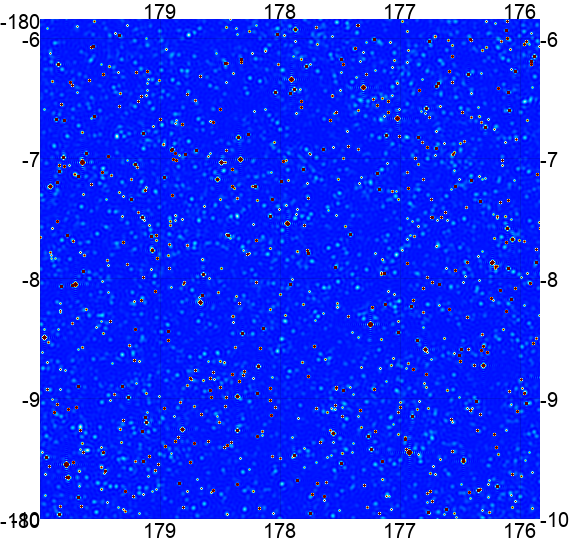

In [94]:
enplot.pshow(pts_map[-1,:500,:500])

In [5]:
output_path("sehgal_validation141020")

'/home/dwhan89/workspace/cosmikyu/data/sehgal/sehgal_validation141020'

In [ ]:
'''
input_dirv2 = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/rotated_lmax10000_20mjycutsv2"
def input_pathv2(rot_angle1, rot_angle2, compt_idx, dtype):
    freq_idx = "" if compt_idx == "kappa" else "148_"
    file_name = "%s%s_%s_%s_%s_000.fits" %(freq_idx, compt_idx, dtype, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
    return os.path.join(input_dirv2, file_name)

def get_input_mapv2(rot_angle1, rot_angle2, nshape, nwcs, compts=compts):
    ishape = nshape[-2:]
    ret = enmap.zeros(nshape, nwcs)
    for i, compt_idx in enumerate(compts):
        dtype = "enmap" if compt_idx == "rad_pts" else "alm"
        input_file = input_pathv2(rot_angle1, rot_angle2, compt_idx, dtype)
        print("loading", input_file)
        if dtype == "alm":
            alm = np.complex128(hp.read_alm(input_file, hdu=(1)))
            ret[i,...] = curvedsky.alm2map(alm, enmap.zeros(ishape, nwcs))
            del alm
        else:
            ret[i,...] = enmap.read_fits(input_file)
    return ret

testv2 = get_input_mapv2(15,20, nshape, nwcs)

idx = -2
alm1 = curvedsky.map2alm(test[idx], lmax=10000)
alm2 = curvedsky.map2alm(testv2[idx], lmax=10000)


cl1 = hp.alm2cl(alm1)
cl2 = hp.alm2cl(alm2)
clx = hp.alm2cl(alm1, alm2)
l = np.arange(len(cl1))
plt.plot(cl1*l**2)
plt.plot(cl2*l**2)
plt.plot(clx*l**2)
plt.yscale("log")
plt.show()

rho = clx/np.sqrt(cl1*cl2)

plt.plot(rho)
'''